# Environment Setup

In [2]:
from config import *
from test_bad_word import *
from utility import *

import time
import numpy as np
import pandas as pd
#pd.options.display.max_columns = None
#pd.options.display.mpl_style = 'default'

import re
import os
import sys
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from scipy import sparse

from nltk.stem.snowball import SnowballStemmer

stemmer = SnowballStemmer('english')

## 1. Import raw data

In [3]:
df_train = pd.read_csv(DATA_DIR + '/train.csv', encoding="ISO-8859-1")
df_train['length']=df_train['Comment'].map(lambda x:len(x.split()))
df_train = df_train[df_train['length']<300]
df_test = pd.read_csv(DATA_DIR + '/test_with_solutions.csv', encoding="ISO-8859-1")

num_train = df_train.shape[0]
num_test = df_test.shape[0]

df_all = pd.concat((df_train, df_test), axis=0, ignore_index=True)

In [4]:
df_all.shape

(6568, 5)

In [5]:
df_all['Comment']=df_all['Comment'].map(lambda x:parser(x))
df_all['Comment']=df_all['Comment'].map(lambda x:badword_replacer(x))
df_all['Comment_stemmed']=df_all['Comment'].map(lambda x: ' '.join([stemmer.stem(word) for word in x.split()]))

df_train['Comment']=df_train['Comment'].map(lambda x:parser(x))
df_train['Comment']=df_train['Comment'].map(lambda x:badword_replacer(x))
df_train['Comment_stemmed']=df_train['Comment'].map(lambda x: ' '.join([stemmer.stem(word) for word in x.split()]))

In [6]:
bad_word_1  = [line.rstrip('\n') for line in open('wordlist/google_bad_word.txt')]
#bad_word_2  = [line.rstrip('\n') for line in open('handcrafted_badword.txt')]
bad_word= set(bad_word_1  + test_bad_word) 

In [7]:
df_dependency = pd.read_csv(PROCESSINGTEXT_DIR + '/dependency.csv')
df_dependency = df_dependency.drop_duplicates()
df_all = pd.merge(df_all, df_dependency, how='left', on='Comment')

In [8]:
df_all.shape

(6568, 7)

## 2. Construct features

* syntatic features

In [9]:
from nltk.parse.stanford import StanfordDependencyParser
import graphviz
import os
os.environ['JAVAHOME'] =  "../../../Program Files (x86)/Java/jre1.8.0_131/bin/java.exe" 

In [10]:
path_to_jar = '../stanford-parser-full-2014-08-27/stanford-parser.jar'
path_to_models_jar = '../stanford-parser-full-2014-08-27/stanford-parser-3.4.1-models.jar'
dependency_parser = StanfordDependencyParser(path_to_jar=path_to_jar, path_to_models_jar=path_to_models_jar)

result = dependency_parser.raw_parse('you are a loser ')
dep = result.__next__()
list(dep.triples())

# X <----- Y

[(('loser', 'NN'), 'nsubj', ('you', 'PRP')),
 (('loser', 'NN'), 'cop', ('are', 'VBP')),
 (('loser', 'NN'), 'det', ('a', 'DT'))]

In [12]:
result = dependency_parser.raw_parse('you are such a loser')
dep = result.__next__()
list(dep.triples())

[(('loser', 'NN'), 'nsubj', ('you', 'PRP')),
 (('loser', 'NN'), 'cop', ('are', 'VBP')),
 (('loser', 'NN'), 'predet', ('such', 'PDT')),
 (('loser', 'NN'), 'det', ('a', 'DT'))]

In [12]:
def obsub(x):
    try:
        x = eval(x)
    except:
        return 0
    if x ==[]:
        return 0
    n = 0 
    for i in x[0]:
        if i != []:
            if i[1] in  ['dobj','iobj','nsubj','nsubjpass','xsubj','agent'] and (i[0][0].lower() in bad_word):
                n +=1
    return n
        

def descriptive(x):
    try:
        x = eval(x)
    except:
        return 0
    if x ==[]:
        return 0
    n = 0 
    for i in x[0]:
        if i != []:
            if i[1] in  ['abbrev','acomp','amod','appos','nn','partmod'] and i[2][0].lower() in bad_word:
                n +=1
    return n 

def possession(x):
    try:
        x = eval(x)
    except:
        return 0
    if x ==[]:
        return 0
    n = 0 
    for i in x[0]:
        if i != []:
            if i[1] in  ['poss'] and i[0][0].lower() in bad_word:
                n +=1
    return n 

def rhetorical(x):
    try:
        x = eval(x)
    except:
        return 0
    if x ==[]:
        return 0
    n = 0 
    for i in x[0]:
        if i != []:
            if i[1] in  ['rcmod '] and i[0][0].lower() in bad_word:
                n +=1
    return n 

def close_phrase(input):
    try:
        x = eval(x)
    except:
        return 0
    if x ==[]:
        return 0
    n = 0 
    for i in x[0]:
        if i != []:
            if i[1] in  ['conj','parataxis'] and (i[0][0].lower() in bad_word or i[2][0].lower() in bad_word):
                n +=1
    return n 

In [13]:
df_all['syn obsub']= df_all['Dependency'].map(lambda x: obsub(x))
df_all['syn descriptive']= df_all['Dependency'].map(lambda x: descriptive(x))
df_all['syn possession']= df_all['Dependency'].map(lambda x: possession(x))
df_all['syn rhetorical']= df_all['Dependency'].map(lambda x: rhetorical(x))
df_all['syn close']= df_all['Dependency'].map(lambda x: close_phrase(x))
df_all['syn sum']=df_all['syn obsub'] + df_all['syn descriptive'] + df_all['syn possession'] + \
                  df_all['syn rhetorical'] + df_all['syn close']

In [14]:
syn_obsub = sparse.csr_matrix(df_all['syn obsub'].values).T
syn_descriptive = sparse.csr_matrix(df_all['syn descriptive'].values).T
syn_possession = sparse.csr_matrix(df_all['syn possession'].values).T
syn_rhetorical = sparse.csr_matrix(df_all['syn rhetorical'].values).T
syn_close = sparse.csr_matrix(df_all['syn close'].values).T
syn_sum = sparse.csr_matrix(df_all['syn sum'].values).T

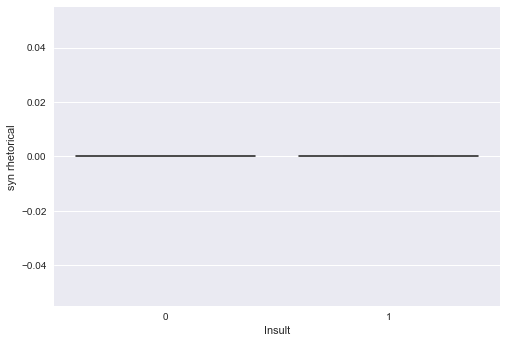

In [24]:
sns.boxplot(x='Insult', y='syn rhetorical', data=df_all)

In [15]:
features = []

features.append(syn_obsub)
features.append(syn_descriptive)
features.append(syn_possession) 
features.append(syn_rhetorical)
features.append(syn_close)
features.append(syn_sum)

features = sparse.hstack(features).tocsr()
features

<6568x6 sparse matrix of type '<class 'numpy.int64'>'
	with 3441 stored elements in Compressed Sparse Row format>

## 3. Models

* Define Train/Test Sets

In [16]:
X_train = features[:num_train]
X_test = features[num_train:]

y_train = df_train['Insult'].values
y_test = df_test['Insult'].values

* Models

In [20]:
from sklearn.ensemble import BaggingClassifier,RandomForestClassifier,GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC

t_1 = time.time()

#clf = RandomForestClassifier(n_estimators=2500, max_depth=15, random_state=2017)
#clf = BaggingClassifier(clf, n_estimators=100, max_samples=0.1, random_state=2017)
#clf = LinearSVC(C=0.1, class_weight={0:1,1:5})
clf = LogisticRegression(tol=1e-8, penalty='l2', C=2,class_weight={0:1,1:4})
clf.fit(X_train, y_train)
y_pred_prob = clf.predict_proba(X_test)[:,1]
y_pred = clf.predict(X_test)

'model training time:',round((time.time()-t_1)/60,1) ,'minutes\n'

('model training time:', 0.0, 'minutes\n')

In [21]:
from sklearn.metrics import roc_auc_score, f1_score
roc_auc_score(y_test,y_pred_prob)

0.67885353018413408

In [22]:
f1_score(y_test, y_pred)

0.51411589895988108